# Minimal analysis
---

#### Overview
Processes timelapse data from intrinsic imaging experiments on mice.

#### Outline
1. Process csv
2. ~~Drift alignment~~
3. ~~Bleah correction~~
4. ~~High-pass filtering~~
5. Frame averaging

#### Packages

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Local modules

In [1]:
from neuroprocessing.scripts.parse_csv import parse_csv, process_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ModuleNotFoundError: No module named 'parse_csv'

## Collect experimental data and process csv

#### Parse csv

In [9]:
from pathlib import Path

from natsort import natsorted
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, filters

from neuroprocessing.scripts.parse_csv import parse_csv, process_data
# location where all experimental data is kept
# /Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/2024-02-29/Zyla_15min_LHL_salineinj_withpushbutton_1
dir_experiments = Path("/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/")

# path to a particular (or set of) experiment(s) for analysis
date = "2024-02-29"
expt = "Zyla_5min_LHLstim_2son4soff_1pt25pctISO_3"
fp_csv = natsorted((dir_experiments/date/expt).glob("*.csv"))[0]
fp_tif = natsorted((dir_experiments/date/expt).glob("*.tif"))[0]

# parse csv and show a preview
df_daq = parse_csv(fp_csv)
df_daq.head(8)

,time,camera,LED1,LED2,stim,button
0,0.00000,0.129435,-0.004598,0.272489,0.183563,-0.008464
1,0.00025,0.125569,-0.004598,0.384612,0.179697,-0.008464
2,0.00050,0.128146,-0.005886,0.420698,0.197740,-0.009753
3,0.00075,0.128146,-0.003309,0.432297,0.210628,-0.008464
4,0.00100,0.128146,-0.004598,0.436163,0.218360,-0.008464
5,0.00125,0.128146,-0.005886,0.437452,0.220938,-0.008464
6,0.00150,0.128146,-0.005886,0.437452,0.220938,-0.008464
7,0.00175,0.126857,-0.007175,0.437452,0.222227,-0.008464


#### Process csv

In [11]:
# check column headers in above DataFrame for
# proper names for camera and stimulation columns
df_frames = process_data(
    df_daq,
    col_camera="camera",
    col_stim="stim"
)

# show preview of processed DataFrame around a stimulation event
i_stim = df_frames.loc[df_frames["stimulated"], "frame"].iloc[0]
df_frames.iloc[i_stim-5:i_stim+3]

,frame,stimulated,time,frametime,framerate
29202,31,False,7.3005,0.1,10.0
29602,32,False,7.4005,0.1,10.0
30002,33,False,7.5005,0.1,10.0
30402,34,False,7.6005,0.1,10.0
30802,35,True,7.7005,0.1,10.0
31202,36,True,7.8005,0.1,10.0
31602,37,True,7.9005,0.1,10.0
32002,38,True,8.0005,0.1,10.0


#### Load timelapse

In [10]:
stack = io.imread(fp_tif)

## Math

In [12]:
frames_base = df_frames.loc[~df_frames["stimulated"], "frame"].values
frames_stim = df_frames.loc[df_frames["stimulated"], "frame"].values


stack_base = stack[frames_base-1]
stack_stim = stack[frames_stim-1]

tproj_base = stack_base.mean(axis=0)
tproj_stim = stack_stim.mean(axis=0)

image_diff = tproj_stim - tproj_base

## Plotting

#### Simplest little plot ya ever did see

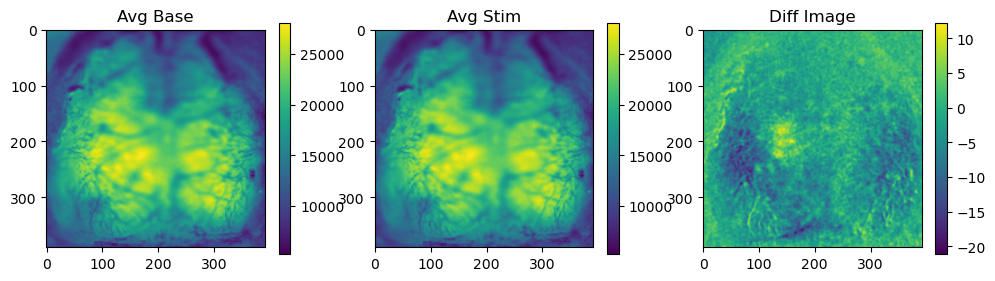

In [13]:
# images to plot
images = {
    "Avg Base": tproj_base,
    "Avg Stim": tproj_stim,
    "Diff Image": filters.gaussian(image_diff, sigma=1.6)
}

# create figure
ncols = len(images)
fig, axes = plt.subplots(
    ncols=ncols,
    figsize=(4*ncols, 3)
)
for (title, image), ax in zip(images.items(), axes):
    ax.imshow(image)
    ax.set_title(title)
    # colorbar
    cbar = plt.colorbar(ax.imshow(image), ax=ax)

#### A little more sophisticato

In [27]:
from fancy_plot import fancy_plot

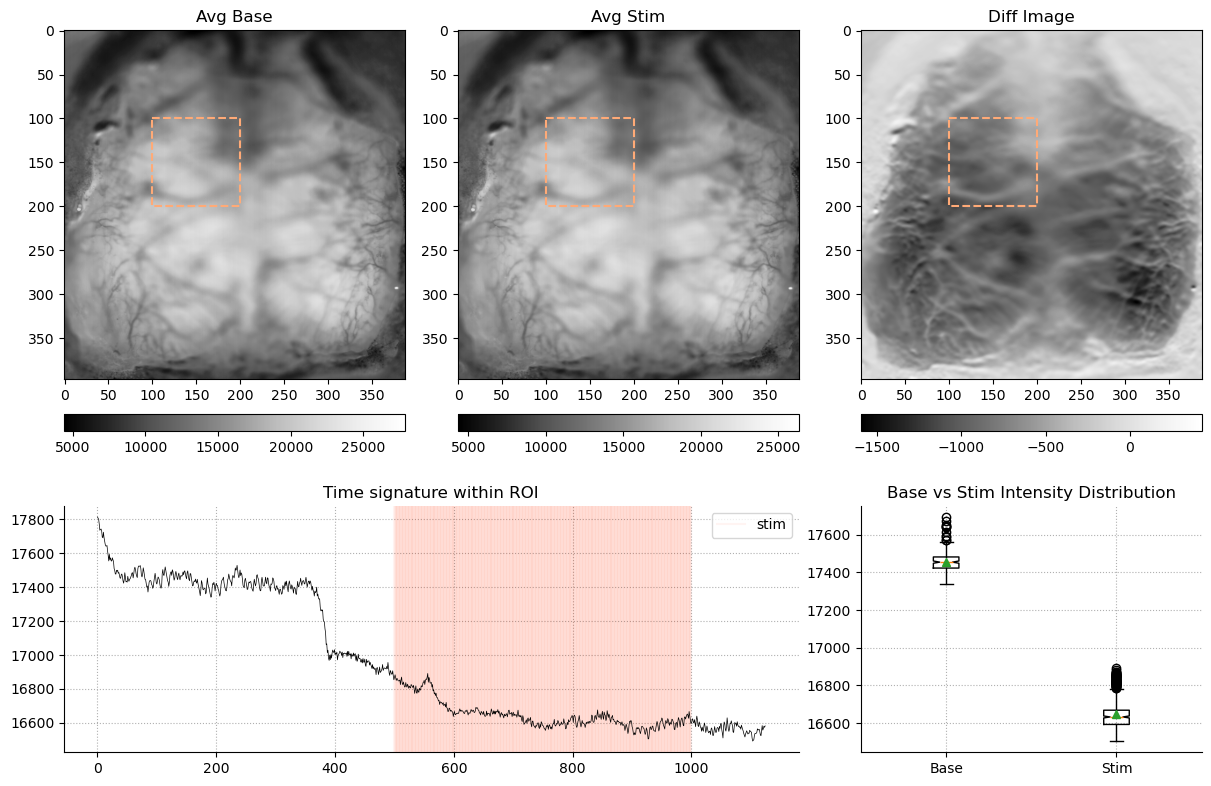

In [28]:
# define ROI
roi = {
    "center": (150, 150),  # (x, y)
    "width": 100,
    "height": 100
}

# make a fancy plot
fancy_plot(
    stack,
    frames_base,
    frames_stim,
    images,
    roi,
)